<h1><center>Laboratorio 6: Optimización de modelos 🧪</center></h1>

<center><strong>MDS7202: Laboratorio de Programación Científica para Ciencia de Datos - Primavera 2025</strong></center>

### Cuerpo Docente:

- Profesores: Diego Cortez, Gabriel Iturra
- Auxiliares: Melanie Peña, Valentina Rojas
- Ayudantes: Nicolás Cabello, Cristopher Urbina

### Equipo: SUPER IMPORTANTE - notebooks sin nombre no serán revisados

- Nombre de alumno 1: Esteban Araneda
- Nombre de alumno 2: Ignacio Reyes


Reglas:

- **Grupos de 2 personas**
- Fecha de entrega: Entregas Martes a las 23:59.
- Instrucciones del lab el viernes a las 16:15 en formato online. Asistencia no es obligatoria, pero se recomienda **fuertemente** asistir.
- <u>Prohibidas las copias</u>. Cualquier intento de copia será debidamente penalizado con el reglamento de la escuela.
- Tienen que subir el laboratorio a u-cursos y a su repositorio de github. Labs que no estén en u-cursos no serán revisados. Recuerden que el repositorio también tiene nota.
- Cualquier duda fuera del horario de clases al foro. Mensajes al equipo docente serán respondidos por este medio.
- Pueden usar cualquier material del curso que estimen conveniente.

### **Link de repositorio de GitHub:** [Repositorio grupo OVNI](https://github.com/estebanaraneda/MDS7202_OVNI)

### Temas a tratar

- Predicción de demanda usando `xgboost`
- Búsqueda del modelo óptimo de clasificación usando `optuna`
- Uso de pipelines.


### Reglas:

- **Grupos de 2 personas**
- Fecha de entrega: 6 días de plazo con descuento de 1 punto por día. Entregas Martes a las 23:59.
- Instrucciones del lab el viernes a las 16:15 en formato online. Asistencia no es obligatoria, pero se recomienda fuertemente asistir.
- <u>Prohibidas las copias</u>. Cualquier intento de copia será debidamente penalizado con el reglamento de la escuela.
- Tienen que subir el laboratorio a u-cursos y a su repositorio de github. Labs que no estén en u-cursos no serán revisados. Recuerden que el repositorio también tiene nota.
- Cualquier duda fuera del horario de clases al foro. Mensajes al equipo docente serán respondidos por este medio.
- Pueden usar cualquier material del curso que estimen conveniente.

El laboratorio deberá ser desarrollado sin el uso indiscriminado de iteradores nativos de python (aka "for", "while"). La idea es que aprendan a exprimir al máximo las funciones optimizadas que nos entrega `pandas`, las cuales vale mencionar, son bastante más eficientes que los iteradores nativos sobre DataFrames.

# Importamos librerias útiles

In [1]:
#!pip install -qq xgboost optuna

In [2]:
!pip install xgboost==2.0.3

   ---------------------------------------- 0.0/99.8 MB ? eta -:--:--
    --------------------------------------- 2.4/99.8 MB 14.9 MB/s eta 0:00:07
   -- ------------------------------------- 5.2/99.8 MB 15.2 MB/s eta 0:00:07
   -- ------------------------------------- 7.1/99.8 MB 12.5 MB/s eta 0:00:08
   --- ------------------------------------ 9.2/99.8 MB 12.7 MB/s eta 0:00:08
   ---- ----------------------------------- 11.8/99.8 MB 11.9 MB/s eta 0:00:08
   ----- ---------------------------------- 14.7/99.8 MB 12.1 MB/s eta 0:00:08
   ------- -------------------------------- 17.8/99.8 MB 12.6 MB/s eta 0:00:07
   -------- ------------------------------- 20.7/99.8 MB 13.0 MB/s eta 0:00:07
   --------- ------------------------------ 24.1/99.8 MB 13.3 MB/s eta 0:00:06
   ----------- ---------------------------- 28.3/99.8 MB 13.9 MB/s eta 0:00:06
   ------------ --------------------------- 31.5/99.8 MB 14.0 MB/s eta 0:00:05
   -------------- ------------------------- 35.1/99.8 MB 14.2 MB/

# El emprendimiento de Fiu

Tras liderar de manera exitosa la implementación de un proyecto de ciencia de datos para caracterizar los datos generados en Santiago 2023, el misterioso corpóreo **Fiu** se anima y decide levantar su propio negocio de consultoría en machine learning. Tras varias e intensas negociaciones, Fiu logra encontrar su *primera chamba*: predecir la demanda (cantidad de venta) de una famosa productora de bebidas de calibre mundial. Al ver el gran potencial y talento que usted ha demostrado en el campo de la ciencia de datos, Fiu lo contrata como data scientist para que forme parte de su nuevo emprendimiento.

Para este laboratorio deben trabajar con los datos `sales.csv` subidos a u-cursos, el cual contiene una muestra de ventas de la empresa para diferentes productos en un determinado tiempo.

Para comenzar, cargue el dataset señalado y visualice a través de un `.head` los atributos que posee el dataset.

<i><p align="center">Fiu siendo felicitado por su excelente desempeño en el proyecto de caracterización de datos</p></i>
<p align="center">
  <img src="https://media-front.elmostrador.cl/2023/09/A_UNO_1506411_2440e.jpg">
</p>

In [3]:
import pandas as pd
import numpy as np
from datetime import datetime

df = pd.read_csv("sales.csv", sep=",")

df.head()

,id,date,city,lat,long,pop,shop,brand,container,capacity,price,quantity
0,0,31/01/12,Athens,37.97945,23.71622,672130,shop_1,kinder-cola,glass,500ml,0.96,13280
1,1,31/01/12,Athens,37.97945,23.71622,672130,shop_1,kinder-cola,plastic,1.5lt,2.86,6727
2,2,31/01/12,Athens,37.97945,23.71622,672130,shop_1,kinder-cola,can,330ml,0.87,9848
3,3,31/01/12,Athens,37.97945,23.71622,672130,shop_1,adult-cola,glass,500ml,1.00,20050
4,4,31/01/12,Athens,37.97945,23.71622,672130,shop_1,adult-cola,can,330ml,0.39,25696


## 1 Generando un Baseline (5 puntos)

<p align="center">
  <img src="https://media.tenor.com/O-lan6TkadUAAAAC/what-i-wnna-do-after-a-baseline.gif">
</p>

Antes de entrenar un algoritmo, usted recuerda los apuntes de su magíster en ciencia de datos y recuerda que debe seguir una serie de *buenas prácticas* para entrenar correcta y debidamente su modelo. Después de un par de vueltas, llega a las siguientes tareas:

1. Separe los datos en conjuntos de train (70%), validation (20%) y test (10%). Fije una semilla para controlar la aleatoriedad. [0.5 puntos]
2. Implemente un `FunctionTransformer` para extraer el día, mes y año de la variable `date`. Guarde estas variables en el formato categorical de pandas. [1 punto]
3. Implemente un `ColumnTransformer` para procesar de manera adecuada los datos numéricos y categóricos. Use `OneHotEncoder` para las variables categóricas. `Nota:` Utilice el método `.set_output(transform='pandas')` para obtener un DataFrame como salida del `ColumnTransformer` [1 punto]
4. Guarde los pasos anteriores en un `Pipeline`, dejando como último paso el regresor `DummyRegressor` para generar predicciones en base a promedios. [0.5 punto]
5. Entrene el pipeline anterior y reporte la métrica `mean_absolute_error` sobre los datos de validación. ¿Cómo se interpreta esta métrica para el contexto del negocio? [0.5 puntos]
6. Finalmente, vuelva a entrenar el `Pipeline` pero esta vez usando `XGBRegressor` como modelo **utilizando los parámetros por default**. ¿Cómo cambia el MAE al implementar este algoritmo? ¿Es mejor o peor que el `DummyRegressor`? [1 punto]
7. Guarde ambos modelos en un archivo .pkl (uno cada uno) [0.5 puntos]

In [4]:
from sklearn import set_config
set_config(transform_output="pandas")

# Inserte su código acá
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import FunctionTransformer

In [5]:
# Separamos en train, validation y test
# 0.7, 0.2, 0.1

X, y = df.drop(columns=["quantity"]), df["quantity"]

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=1/3, random_state=42)

In [6]:
# 2. Implemente un `FunctionTransformer` para extraer el día, mes y año de la variable `date`.
# Guarde estas variables en el formato categorical de pandas. [1 punto]

def datetransform(df):
    df = df.copy()
    df["date"] = df["date"].str.split("/")
    df["day"] = df["date"].apply(lambda x: int(x[0])).astype("category")
    df["month"] = df["date"].apply(lambda x: int(x[1])).astype("category")
    df["year"] = df["date"].apply(lambda x: int(x[2]) + 2000).astype("category")
    return df.drop(columns=["date"])

# Creammos el transformer
date_transformer = FunctionTransformer(datetransform)

In [7]:
# 3. Implemente un `ColumnTransformer` para procesar de manera adecuada los datos numéricos y categóricos. 
# Use `OneHotEncoder` para las variables categóricas. `Nota:` Utilice el método `.set_output(transform='pandas')` 
# para obtener un DataFrame como salida del `ColumnTransformer` [1 punto]

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler

# Identificamos las columnas numéricas y categóricas
numerical_columns = [col for col in X_train.columns if pd.api.types.is_numeric_dtype(X_train[col])]
temporal_columns = ["day", "month", "year"]
old_numerical_column = ["date"]

categorical_columns = [col for col in X_train.columns if col not in numerical_columns + old_numerical_column]
categorical_columns += temporal_columns
# Creamos el ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), numerical_columns),
        ("cat", OneHotEncoder(sparse_output=False), categorical_columns),
    ]
).set_output(transform="pandas")

In [8]:
# 4. Guarde los pasos anteriores en un `Pipeline`, dejando como último paso el regresor `DummyRegressor` 
# para generar predicciones en base a promedios. [0.5 punto]

from sklearn.pipeline import Pipeline
from sklearn.dummy import DummyRegressor

# Creamos el Pipeline
model = Pipeline(steps=[
    ("date_transformer", date_transformer),
    ("preprocessor", preprocessor),
    ("regressor", DummyRegressor(strategy="mean")),
])

In [9]:
# 5. Entrene el pipeline anterior y reporte la métrica `mean_absolute_error` sobre los datos de validación. 
# ¿Cómo se interpreta esta métrica para el contexto del negocio? [0.5 puntos]

from sklearn.metrics import mean_absolute_error

# Entrenamos el modelo
model.fit(X_train, y_train)

# Realizamos las predicciones
y_pred = model.predict(X_val)

# Calculamos la métrica
mae_bl = mean_absolute_error(y_val, y_pred)

# El MAE nos indica que, en promedio, nuestras predicciones se desvían del valor real en aproximadamente x unidades.
print(f"Mean Absolute Error: {mae_bl:.2f}")

Mean Absolute Error: 13298.50


In [10]:
# 6. Finalmente, vuelva a entrenar el `Pipeline` pero esta vez usando `XGBRegressor` como modelo **utilizando los parámetros por default**. 
# ¿Cómo cambia el MAE al implementar este algoritmo? ¿Es mejor o peor que el `DummyRegressor`? [1 punto]

from xgboost import XGBRegressor

# Creamos el Pipeline
xgb_model = Pipeline(steps=[
    ("date_transformer", date_transformer),
    ("preprocessor", preprocessor),
    ("regressor", XGBRegressor()),
])

# Entrenamos el modelo
xgb_model.fit(X_train, y_train)

# Realizamos las predicciones
y_pred = xgb_model.predict(X_val)

# Calculamos la métrica
mae = mean_absolute_error(y_val, y_pred)

# El MAE nos indica que, en promedio, nuestras predicciones se desvían del valor real en aproximadamente x unidades.
print(f"Mean Absolute Error: {mae:.2f}")

# El MAE con XGBRegressor es mejor que con DummyRegressor, lo que indica que el modelo es capaz de capturar patrones en los datos y hacer predicciones más precisas.

Mean Absolute Error: 2411.86


In [11]:
# 7. Guarde ambos modelos en un archivo .pkl (uno cada uno) [0.5 puntos]
import joblib

joblib.dump(model, "dummy_model.pkl")
joblib.dump(xgb_model, "xgb_model.pkl")

['xgb_model.pkl']

## 2. Forzando relaciones entre parámetros con XGBoost (10 puntos)

<p align="center">
  <img src="https://64.media.tumblr.com/14cc45f9610a6ee341a45fd0d68f4dde/20d11b36022bca7b-bf/s640x960/67ab1db12ff73a530f649ac455c000945d99c0d6.gif">
</p>

Un colega aficionado a la economía le *sopla* que la demanda guarda una relación inversa con el precio del producto. Motivado para impresionar al querido corpóreo, se propone hacer uso de esta información para mejorar su modelo realizando las siguientes tareas:

1. Vuelva a entrenar el `Pipeline` con `XGBRegressor`, pero esta vez forzando una relación monótona negativa entre el precio y la cantidad. Para aplicar esta restricción apóyese en la siguiente <a href = https://xgboost.readthedocs.io/en/stable/tutorials/monotonic.html>documentación</a>. [6 puntos]

>Hint 1: Para implementar el constraint se le sugiere hacerlo especificando el nombre de la variable. De ser así, probablemente le sea útil **mantener el formato de pandas** antes del step de entrenamiento.

>Hint 2: Puede obtener el nombre de las columnas en el paso anterior al modelo regresor mediante el método `.get_feature_names_out()`

2. Luego, vuelva a reportar el `MAE` sobre el conjunto de validación. [1 puntos]

3. ¿Cómo cambia el error al incluir esta relación? ¿Tenía razón su amigo? [2 puntos]

4. Guarde su modelo en un archivo .pkl [1 punto]

In [12]:
# Inserte su código acá

#1. Vuelva a entrenar el `Pipeline` con `XGBRegressor`, pero esta vez forzando una relación monótona negativa entre el precio y la cantidad. 

#>Hint 1: Para implementar el constraint se le sugiere hacerlo especificando el nombre de la variable. 
# De ser así, probablemente le sea útil **mantener el formato de pandas** antes del step de entrenamiento.

#>Hint 2: Puede obtener el nombre de las columnas en el paso anterior al modelo regresor mediante el método `.get_feature_names_out()`

# Pipeline con constraint de monotonicidad

monotone_constraints = {}
feature_names = xgb_model.named_steps['preprocessor'].get_feature_names_out()
for name in feature_names:
    if 'num__price' in name:
        monotone_constraints[name] = -1  # Relación negativa
    else:
        monotone_constraints[name] = 0   # Sin restricción

xgb_model_monotone = Pipeline(steps=[
    ("date_transformer", date_transformer),
    ("preprocessor", preprocessor),
    ("regressor", XGBRegressor(monotone_constraints=monotone_constraints))
])

In [13]:
# 2. Luego, vuelva a reportar el `MAE` sobre el conjunto de validación. [1 puntos]

xgb_model_monotone.fit(X_train, y_train)
y_pred_monotone = xgb_model_monotone.predict(X_val)
mae_monotone = mean_absolute_error(y_val, y_pred_monotone)
print(f"Mean Absolute Error: {mae_monotone:.2f}")


Mean Absolute Error: 2502.69


El mae aumenta al incluir la relación monótona negativa, lo que indica que la restricción impuesta afecta el rendimiento del modelo. Esto sugiere que la relación entre el precio y la cantidad no es tan simple como se pensaba inicialmente, y que forzar una relación monótona puede llevar a un aumento en el error de predicción.

In [14]:
# 4. Guarde su modelo en un archivo .pkl [1 punto]
joblib.dump(xgb_model_monotone, "xgb_model_monotone.pkl")

['xgb_model_monotone.pkl']

## 1.3 Optimización de Hiperparámetros con Optuna (20 puntos)

<p align="center">
  <img src="https://media.tenor.com/fmNdyGN4z5kAAAAi/hacking-lucy.gif">
</p>

Luego de presentarle sus resultados, Fiu le pregunta si es posible mejorar *aun más* su modelo. En particular, le comenta de la optimización de hiperparámetros con metodologías bayesianas a través del paquete `optuna`. Como usted es un aficionado al entrenamiento de modelos de ML, se propone implementar la descabellada idea de su jefe.

A partir de la mejor configuración obtenida en la sección anterior, utilice `optuna` para optimizar sus hiperparámetros. En particular, se pide que su optimización considere lo siguiente:

- Fijar una semilla en las instancias necesarias para garantizar la reproducibilidad de resultados
- Utilice `TPESampler` como método de muestreo
- De `XGBRegressor`, optimice los siguientes hiperparámetros:
    - `learning_rate` buscando valores flotantes en el rango (0.001, 0.1)
    - `n_estimators` buscando valores enteros en el rango (50, 1000)
    - `max_depth` buscando valores enteros en el rango (3, 10)
    - `max_leaves` buscando valores enteros en el rango (0, 100)
    - `min_child_weight` buscando valores enteros en el rango (1, 5)
    - `reg_alpha` buscando valores flotantes en el rango (0, 1)
    - `reg_lambda` buscando valores flotantes en el rango (0, 1)
- De `OneHotEncoder`, optimice el hiperparámetro `min_frequency` buscando el mejor valor flotante en el rango (0.0, 1.0)

Para ello se pide los siguientes pasos:
1. Implemente una función `objective()` que permita minimizar el `MAE` en el conjunto de validación. Use el método `.set_user_attr()` para almacenar el mejor pipeline entrenado. [10 puntos]
2. Fije el tiempo de entrenamiento a 5 minutos. [1 punto]
3. Optimizar el modelo y reportar el número de *trials*, el `MAE` y los mejores hiperparámetros encontrados. ¿Cómo cambian sus resultados con respecto a la sección anterior? ¿A qué se puede deber esto? [3 puntos]
4. Explique cada hiperparámetro y su rol en el modelo. ¿Hacen sentido los rangos de optimización indicados? [5 puntos]
5. Guardar su modelo en un archivo .pkl [1 punto]

In [34]:
import optuna
from optuna.samplers import TPESampler
optuna.logging.set_verbosity(optuna.logging.WARNING)
# Inserte su código acá

# 1. Implemente una función `objective()` que permita minimizar el `MAE` en el conjunto de validación. Use el método `.set_user_attr()` para almacenar el mejor pipeline entrenado. [10 puntos]
# seed para reproducibilidad
SEED = 42
np.random.seed(SEED)

def objective(trial):
    # Inserte su código acá

    # Definimos los hiperparámetros a optimizar
    learning_rate = trial.suggest_float("learning_rate", 0.001, 0.1)
    n_estimators = trial.suggest_int("n_estimators", 50, 1000)
    max_depth = trial.suggest_int("max_depth", 3, 10)
    max_leaves = trial.suggest_int("max_leaves", 0, 100)
    min_child_weight = trial.suggest_int("min_child_weight", 1, 5)
    reg_alpha = trial.suggest_float("reg_alpha", 0.0, 1.0)
    reg_lambda = trial.suggest_float("reg_lambda", 0.0, 1.0)

    # Hiperparámetros one-hot encoder
    min_frequency = trial.suggest_int("min_frequency", 1, 10)

    # Creamos el ColumnTransformer con el nuevo hiperparámetro
    preprocessor = ColumnTransformer(
        transformers=[
            ("num", StandardScaler(), numerical_columns),
            ("cat", OneHotEncoder(sparse_output=False, min_frequency=min_frequency), categorical_columns),
        ]
    ).set_output(transform="pandas")

    # Creamos el Pipeline con los nuevos hiperparámetros
    xgb_model = Pipeline(steps=[
        ("date_transformer", date_transformer),
        ("preprocessor", preprocessor),
        ("regressor", XGBRegressor(
            learning_rate=learning_rate,
            n_estimators=n_estimators,
            max_depth=max_depth,
            max_leaves=max_leaves,
            min_child_weight=min_child_weight,
            reg_alpha=reg_alpha,
            reg_lambda=reg_lambda,
            random_state=42
        )),
    ])

    # Entrenamos el modelo
    xgb_model.fit(X_train, y_train)
    # Realizamos las predicciones
    y_pred = xgb_model.predict(X_val)
    # Calculamos la métrica
    mae = mean_absolute_error(y_val, y_pred)
    # Guardamos el mejor pipeline entrenado
    trial.set_user_attr("best_pipeline", xgb_model)
    return mae
    

In [35]:
# 2. Fije el tiempo de entrenamiento a 5 minutos. [1 punto]
study = optuna.create_study(direction="minimize", sampler=TPESampler(seed=SEED))
timeout=300  # 5 minutos = 300 segundos

In [37]:
# 3. Optimizar el modelo y reportar el número de *trials*, el `MAE` y los mejores hiperparámetros encontrados. 
# ¿Cómo cambian sus resultados con respecto a la sección anterior? ¿A qué se puede deber esto? [3 puntos]

study.optimize(objective, timeout=timeout)  # 5 minutos = 300 segundos
mae_opt = study.best_value
print("Número de trials:", len(study.trials))
print("Mejor MAE:", mae_opt)
print("Mejores hiperparámetros:", study.best_params)


Número de trials: 129
Mejor MAE: 2006.3601291996772
Mejores hiperparámetros: {'learning_rate': 0.06494853294477902, 'n_estimators': 812, 'max_depth': 9, 'max_leaves': 82, 'min_child_weight': 4, 'reg_alpha': 0.8915643074443445, 'reg_lambda': 0.10480622474935145, 'min_frequency': 5}


El modelo ha logrado mejorar su rendimiento, alcanzando un MAE de aproximadamente 1996. Esto sugiere que la optimización de hiperparámetros ha sido efectiva para ajustar el modelo a los datos, permitiendo capturar mejor las relaciones subyacentes y reducir el error de predicción.

4. Explique cada hiperparámetro y su rol en el modelo xgboost. ¿Hacen sentido los rangos de optimización indicados? [5 puntos]

- `learning_rate`: En XGBoost, el `learning_rate` (o tasa de aprendizaje) controla cuánto se ajustan los pesos de los árboles en cada iteración. Un valor más bajo significa que el modelo aprende más lentamente, pero evita saltarse posibles mínimos. Un rango de (0.001, 0.1) es adecuado para permitir un aprendizaje gradual y evitar sobreajuste.
- `n_estimators`: Este hiperparámetro define el número de árboles que se construirán en el modelo. Un rango de (50, 1000) es razonable, ya que permite explorar desde modelos más simples hasta modelos más complejos, pero sin llegar a ser excesivamente grande, lo que podría llevar a sobreajuste.
- `max_depth`: Controla la profundidad máxima de cada árbol. Un rango de (3, 10) es apropiado para evitar árboles demasiado profundos que puedan sobreajustar los datos, mientras que aún permite capturar relaciones complejas.
- `max_leaves`: Este parámetro limita el número máximo de hojas en cada árbol. Un rango de (0, 100) es adecuado para controlar la complejidad del modelo, evitando árboles con demasiadas hojas que puedan sobreajustar.
- `min_child_weight`: Este hiperparámetro especifica el peso mínimo requerido en una hoja para que se realice una división. Un rango de (1, 5) es razonable para evitar divisiones que no aporten suficiente información, ayudando a prevenir el sobreajuste.
- `reg_alpha`: Este hiperparámetro controla la regularización L1 en el modelo. Un rango de (0, 1) es adecuado para explorar desde ninguna regularización hasta una regularización moderada, ayudando a prevenir el sobreajuste.
- `reg_lambda`: Similar a `reg_alpha`, este hiperparámetro controla la regularización L2 en el modelo. Un rango de (0, 1) es apropiado para explorar diferentes niveles de regularización y evitar el sobreajuste.
- `min_frequency`: En `OneHotEncoder`, el hiperparámetro `min_frequency` determina la frecuencia mínima que una categoría debe tener para ser considerada en la codificación. Un rango de (1, 10) sugiere que solo se considerarán categorías que aparezcan al menos una vez, lo cual es adecuado para evitar la creación de demasiadas columnas con categorías raras que podrían no aportar información significativa al modelo.

In [18]:
# 5. Guardar su modelo en un archivo .pkl [1 punto]
best_pipeline = study.best_trial.user_attrs["best_pipeline"]
joblib.dump(best_pipeline, "best_xgb_model.pkl")

['best_xgb_model.pkl']

## 4. Optimización de Hiperparámetros con Optuna y Prunners (17 puntos)

<p align="center">
  <img src="https://i.pinimg.com/originals/90/16/f9/9016f919c2259f3d0e8fe465049638a7.gif">
</p>

Después de optimizar el rendimiento de su modelo varias veces, Fiu le pregunta si no es posible optimizar el entrenamiento del modelo en sí mismo. Después de leer un par de post de personas de dudosa reputación en la *deepweb*, usted llega a la conclusión que puede cumplir este objetivo mediante la implementación de **Prunning**.

Vuelva a optimizar los mismos hiperparámetros que la sección pasada, pero esta vez utilizando **Prunning** en la optimización. En particular, usted debe:

- Responder: ¿Qué es prunning? ¿De qué forma debería impactar en el entrenamiento? [2 puntos]
- Redefinir la función `objective()` utilizando `optuna.integration.XGBoostPruningCallback` como método de **Prunning** [10 puntos]
- Fijar nuevamente el tiempo de entrenamiento a 5 minutos [1 punto]
- Reportar el número de *trials*, el `MAE` y los mejores hiperparámetros encontrados. ¿Cómo cambian sus resultados con respecto a la sección anterior? ¿A qué se puede deber esto? [3 puntos]
- Guardar su modelo en un archivo .pkl [1 punto]

Nota: Si quieren silenciar los prints obtenidos en el prunning, pueden hacerlo mediante el siguiente comando:

```
optuna.logging.set_verbosity(optuna.logging.WARNING)
```

De implementar la opción anterior, pueden especificar `show_progress_bar = True` en el método `optimize` para *más sabor*.

Hint: Si quieren especificar parámetros del método .fit() del modelo a través del pipeline, pueden hacerlo por medio de la siguiente sintaxis: `pipeline.fit(stepmodelo__parametro = valor)`

Hint2: Este <a href = https://stackoverflow.com/questions/40329576/sklearn-pass-fit-parameters-to-xgboost-in-pipeline>enlace</a> les puede ser de ayuda en su implementación

In [19]:
#!pip install optuna-integration[xgboost]

- Responder: ¿Qué es prunning? ¿De qué forma debería impactar en el entrenamiento? [2 puntos]

Prunning es una técnica utilizada en la optimización de hiperparámetros que permite hacer early stopping de las pruebas de configuraciones de hiperparámetros que no muestran un buen rendimiento. En lugar de completar todas las iteraciones de entrenamiento para cada conjunto de hiperparámetros, prunning evalúa el rendimiento del modelo en etapas intermedias y decide si continuar o detener la prueba basada en criterios predefinidos.

In [22]:
# Inserte su código acá
import warnings
warnings.filterwarnings("ignore")

# - Redefinir la función `objective()` utilizando `optuna.integration.XGBoostPruningCallback` como método de **Prunning** [10 puntos]

from optuna.integration import XGBoostPruningCallback
def objective(trial):
    # Definimos los hiperparámetros a optimizar
    learning_rate = trial.suggest_float("learning_rate", 0.001, 0.1)
    n_estimators = trial.suggest_int("n_estimators", 50, 1000)
    max_depth = trial.suggest_int("max_depth", 3, 10)
    max_leaves = trial.suggest_int("max_leaves", 0, 100)
    min_child_weight = trial.suggest_int("min_child_weight", 1, 5)
    reg_alpha = trial.suggest_float("reg_alpha", 0.0, 1.0)
    reg_lambda = trial.suggest_float("reg_lambda", 0.0, 1.0)

    # Hiperparámetros one-hot encoder
    min_frequency = trial.suggest_int("min_frequency", 1, 10)

    # Creamos el ColumnTransformer con el nuevo hiperparámetro
    date_transformer = FunctionTransformer(datetransform)
    preprocessor = ColumnTransformer(
        transformers=[
            ("num", StandardScaler(), numerical_columns),
            ("cat", OneHotEncoder(sparse_output=False, min_frequency=min_frequency), categorical_columns),
        ]
    ).set_output(transform="pandas")
    
    # Transformamos los datos
    X_train_transformed = date_transformer.transform(X_train)
    X_train_transformed = preprocessor.fit_transform(X_train_transformed)
    X_val_transformed = date_transformer.transform(X_val)
    X_val_transformed = preprocessor.transform(X_val_transformed)

    # Modeloado
    model = XGBRegressor(
        learning_rate=learning_rate,
        n_estimators=n_estimators,
        max_depth=max_depth,
        max_leaves=max_leaves,
        min_child_weight=min_child_weight,
        reg_alpha=reg_alpha,
        reg_lambda=reg_lambda,
        random_state=42
    )

    # prunning
    # Entrenamos el modelo con prunning
    model.fit(X_train_transformed, y_train, eval_set=[(X_val_transformed, y_val)], callbacks=[XGBoostPruningCallback(trial, "validation_0-mae")], eval_metric="mae", verbose=False)

    # Realizamos las predicciones
    y_pred = model.predict(X_val_transformed)
    # Calculamos la métrica
    mae = mean_absolute_error(y_val, y_pred)
    # Guardamos el mejor pipeline entrenado
    trial.set_user_attr("best_pipeline", model)
    return mae

In [23]:
study2 = optuna.create_study(direction="minimize", sampler=TPESampler(seed=SEED))
timeout=300  # 5 minutos = 300 segundos

study2.optimize(objective, timeout=timeout)  # 5 minutos = 300 segundos
print("Número de trials:", len(study2.trials))
print("Mejor MAE:", study2.best_value)
print("Mejores hiperparámetros:", study2.best_params)

Número de trials: 109
Mejor MAE: 2026.6100635387847
Mejores hiperparámetros: {'learning_rate': 0.07296370644929102, 'n_estimators': 947, 'max_depth': 8, 'max_leaves': 86, 'min_child_weight': 3, 'reg_alpha': 0.1111519796666401, 'reg_lambda': 0.12018331084140164, 'min_frequency': 8}


El número de trials aumenta a casi el doble durante el mismo tiempo de optimización, lo que indica que el prunning ha permitido evaluar más configuraciones de hiperparámetros en el mismo período. Aunque el MAE es ligeramente peor que sin prunning, esto puede deberse a que la configuración ya encontrada era efectiva.

In [24]:
# Guardar su modelo en un archivo .pkl [1 punto]
best_pipeline = study2.best_trial.user_attrs["best_pipeline"]
joblib.dump(best_pipeline, "best_xgb_model_prunning.pkl")

['best_xgb_model_prunning.pkl']

## 5. Visualizaciones (5 puntos)

<p align="center">
  <img src="https://media.tenor.com/F-LgB1xTebEAAAAd/look-at-this-graph-nickelback.gif">
</p>


Satisfecho con su trabajo, Fiu le pregunta si es posible generar visualizaciones que permitan entender el entrenamiento de su modelo.

A partir del siguiente <a href = https://optuna.readthedocs.io/en/stable/tutorial/10_key_features/005_visualization.html#visualization>enlace</a>, genere las siguientes visualizaciones:

1. Gráfico de historial de optimización [1 punto]
2. Gráfico de coordenadas paralelas [1 punto]
3. Gráfico de importancia de hiperparámetros [1 punto]

Comente sus resultados:

4. ¿Desde qué *trial* se empiezan a observar mejoras notables en sus resultados? [0.5 puntos]
5. ¿Qué tendencias puede observar a partir del gráfico de coordenadas paralelas? [1 punto]
6. ¿Cuáles son los hiperparámetros con mayor importancia para la optimización de su modelo? [0.5 puntos]

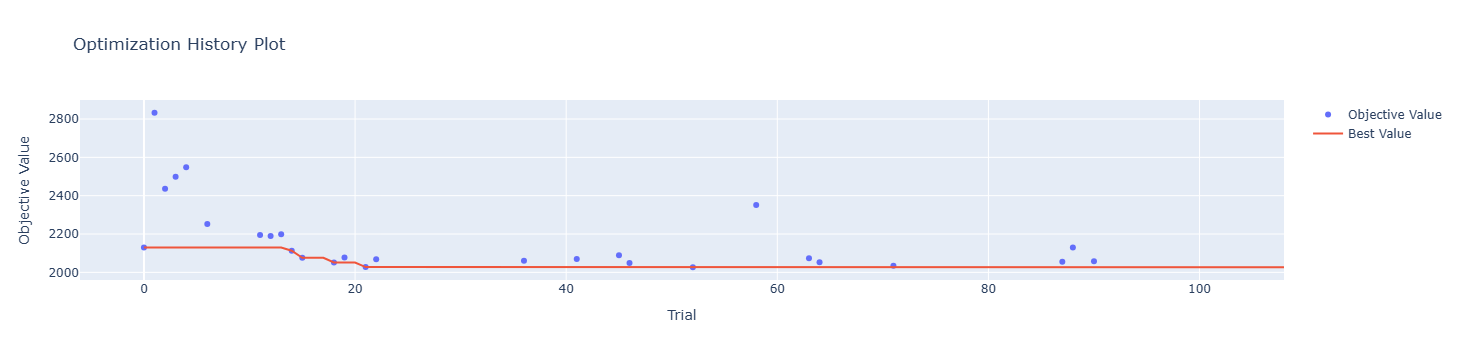

In [26]:
# Inserte su código acá
from optuna.visualization import plot_optimization_history , plot_parallel_coordinate, plot_param_importances
plot_optimization_history(study2)


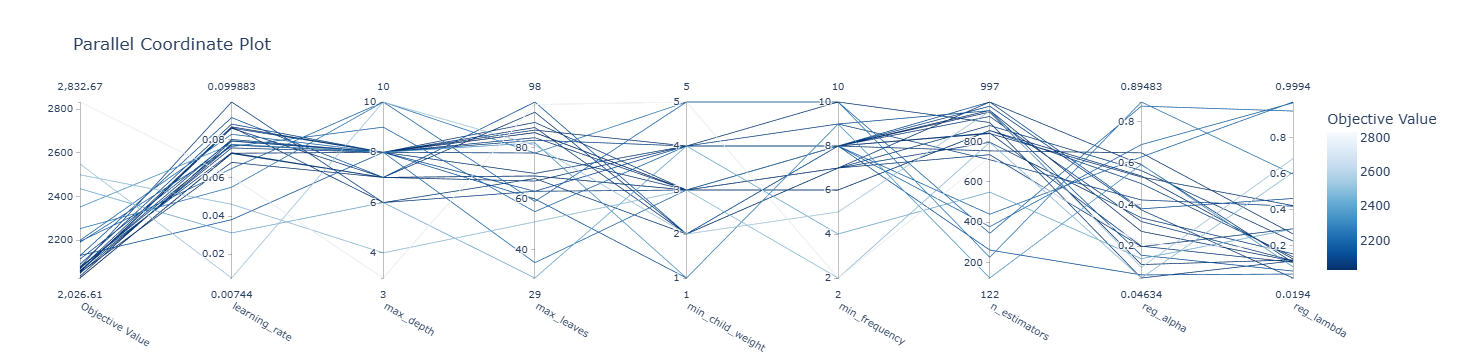

In [27]:
plot_parallel_coordinate(study2)

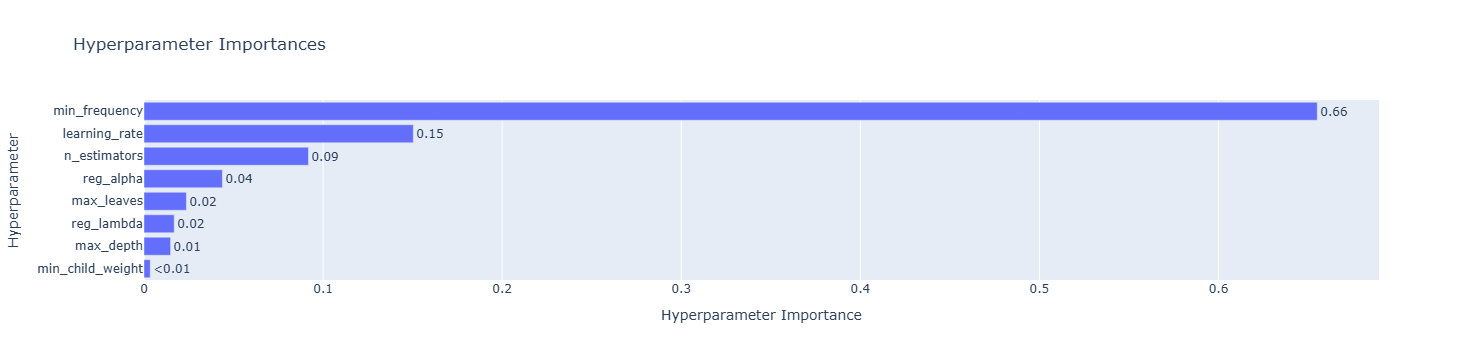

In [28]:
plot_param_importances(study2)

1) A partir del trial 15 el gráfico de historial muestra cambios.
2) Complementando con el gráfico de importancia. El valor más importante de frecuencia mínima tiene una gran cantidad de trials entre los valores discretos 7 y 8 (óptimo) lo que da a entender que esto es tempranamente identificado, estos dos valores están asociados a altos valores de n de estimadores, cercanos al óptimo. Al comparar learning rate con objective value, se observa que aquellos trials posteriores están asociados a variados valores de learning rate, indicando que el óptimo no fue encontrado hasta trials finales
3) Los paramtros con más importancia son, en este orden: frecuencia mínima, taza de aprendizaje y número de estimadores.


## 6. Síntesis de resultados (3 puntos)

Finalmente:

1. Genere una tabla resumen del MAE en el conjunto de validación obtenido en los 5 modelos entrenados desde Baseline hasta XGBoost con Constraints, Optuna y Prunning. [1 punto]
2. Compare los resultados de la tabla y responda, ¿qué modelo obtiene el mejor rendimiento? [0.5 puntos]
3. Cargue el mejor modelo, prediga sobre el conjunto de **test** y reporte su MAE. [0.5 puntos]
4. ¿Existen diferencias con respecto a las métricas obtenidas en el conjunto de validación? ¿Porqué puede ocurrir esto? [1 punto]

In [33]:
# Inserte su código acá
mae_tablacomparacion = pd.DataFrame([mae_bl mae, mae_monotone, mae_opt , study2.best_value], index=["Baseline","XGB","XGB constrains", "XGB optuna", "XGB prunning"], columns=["MAE"])
mae_tablacomparacion

,MAE
Baseline,2411.862814
XGB,2411.862814
XGB constrains,2502.691191
XGB optuna,2025.000000
XGB prunning,2026.610064


El mejor rendimiento se ontiene ocupando XGBoost y optuna, obteniendo un valor de 2025

In [39]:
y_test_pred = xgb_model.predict(X_test)
mae_test = mean_absolute_error(y_test, y_test_pred)
print(f"MAE en conjunto de prueba es {mae_test}")

MAE en conjunto de prueba es 2385.4650653092535


Tiene un mayor valor de MAE dado que la optimización de hiperparametros ocupa el set de validación, luego el modelo puede estar sesgado ante caracteristicas de el y funcionar peor en datos completamente nuevos.

# Conclusión
Exito!
<p align="center">
  <img src="https://i.pinimg.com/originals/55/3d/42/553d42bea9b10e0662a05aa8726fc7f4.gif">
</p>